In [50]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import utils_hugo as ut
from importlib import reload
plt.style.use('default')
reload(ut);

# Loading the data

In [2]:
n_samples = 100
seed=0

In [3]:
bids_dir = "/Users/hugofluhr/DATA/ds003505/"
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', ]
epochs_multi, y_multi = ut.multiple_subjects_epochs(bids_dir=bids_dir, subjects= subjects, tmin=-0.1, tmax=0.5, apply_proj=False, apply_baseline=False)
X, y, S = ut.aggregate_epochs(epochs_multi,y_multi, subjects)
del epochs_multi, y_multi
X_red, y_red, S_red = ut.reduce_trials(X, y, S, n_samples=n_samples, seed=seed)
del X, y, S

Picked 2000 trials out of 5708


In [4]:
X_red.shape

(2000, 128, 151)

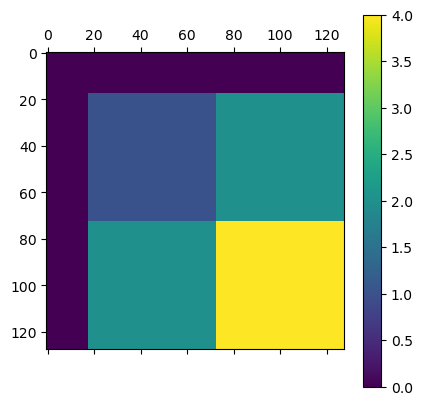

In [5]:
node_order, hemi = ut.get_node_ordering(with_hemi=True)
# use A[np.ix_(node_order, node_order)]  
mask = np.outer(hemi,hemi)
plt.matshow(mask)
plt.colorbar()

In [6]:
np.unique(mask)

array([0, 1, 2, 4])

# Compute Adjacencies

In [51]:
A = ut.compute_graphs_multi(X_red, ut.corr_coef_graph, threshold=False)

In [52]:
A.shape

(2000, 128, 128)

# Graph characterization

- number of nodes and edges/density
- degree distribution (+ moments?)
- path matrices not informative
- diameter
- CC
- assignment 1b : simulate network models to compare to

## Example graphs and variation between subjects and trial types

1


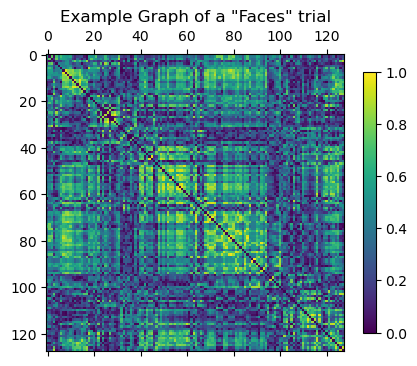

In [75]:
# example graph for Faces trial
a = A[0]
print(y_red[0])
plt.matshow(a[np.ix_(node_order, node_order)][np.ix_(node_order, node_order)], vmax=1)
plt.title('Example Graph of a "Faces" trial')
plt.colorbar(shrink=.7)
plt.show()

0


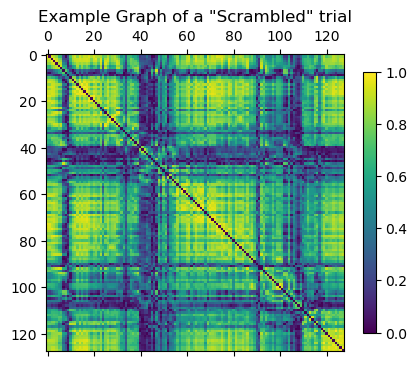

In [76]:
# example graph for Scrambled trial
ind = 2
print(y_red[ind])
plt.matshow(A[ind][np.ix_(node_order, node_order)], vmax=1)
plt.title('Example Graph of a "Scrambled" trial')
plt.colorbar(shrink=.7)
plt.show()

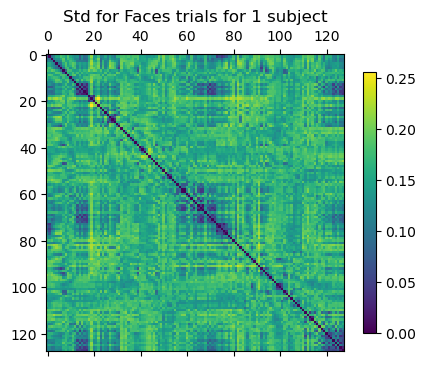

In [77]:
ind = np.logical_and(y_red==1, S_red=='sub-01')
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for Faces trials for 1 subject')
plt.colorbar(shrink=.7)
plt.show()

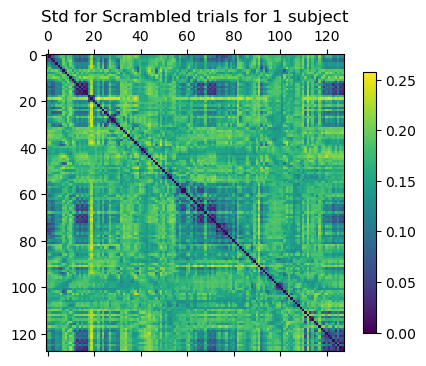

In [78]:
ind = np.logical_and(y_red==0, S_red=='sub-01')
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for Scrambled trials for 1 subject')
plt.colorbar(shrink=.7)
plt.show()

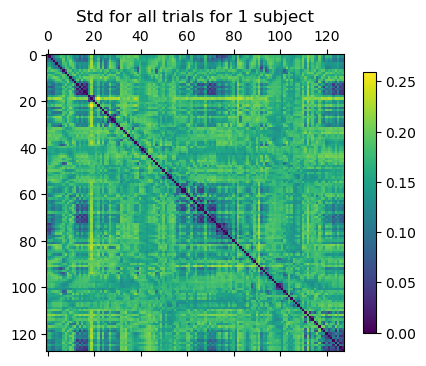

In [79]:
ind = S_red=='sub-01'
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for all trials for 1 subject')
plt.colorbar(shrink=.7)
plt.show()

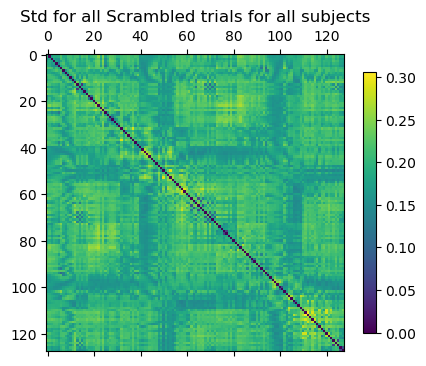

In [80]:
ind = y_red==0
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for all Scrambled trials for all subjects')
plt.colorbar(shrink=.7)
plt.show()

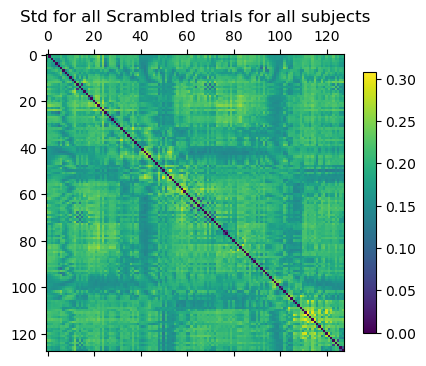

In [81]:
ind = y_red==1
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for all Scrambled trials for all subjects')
plt.colorbar(shrink=.7)
plt.show()

In [22]:
reload(ut)
#dist_matrix = ut.electrode_distances()
dist_geodesic = ut.electrode_distances_geodesic()
#dist_x = ut.electrode_x_distances()

## Edge weight vs electrode distance

Text(0.5, 0, 'electrode geodesic distance')

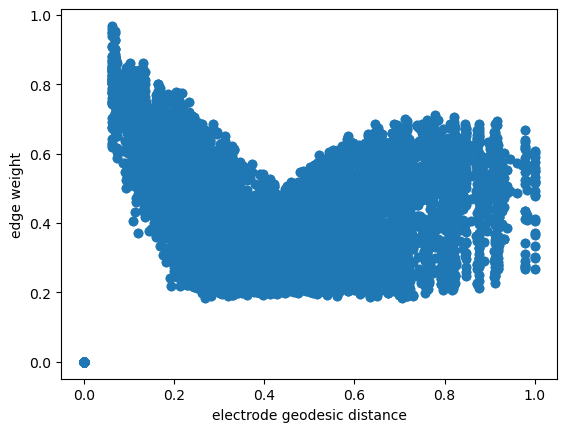

In [53]:
plt.scatter(dist_geodesic.flatten(), A.mean(axis=0).flatten())
plt.ylabel('edge weight')
plt.xlabel('electrode geodesic distance')

In [54]:
A_thresh = ut.threshold_graphs(A, 0.2)

Text(0.5, 0, 'electrode geodesic distance')

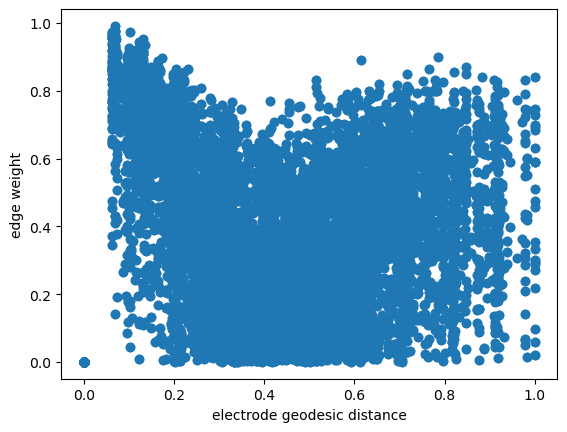

In [56]:
plt.scatter(dist_geodesic.flatten(), A[0].flatten())
plt.ylabel('edge weight')
plt.xlabel('electrode geodesic distance')

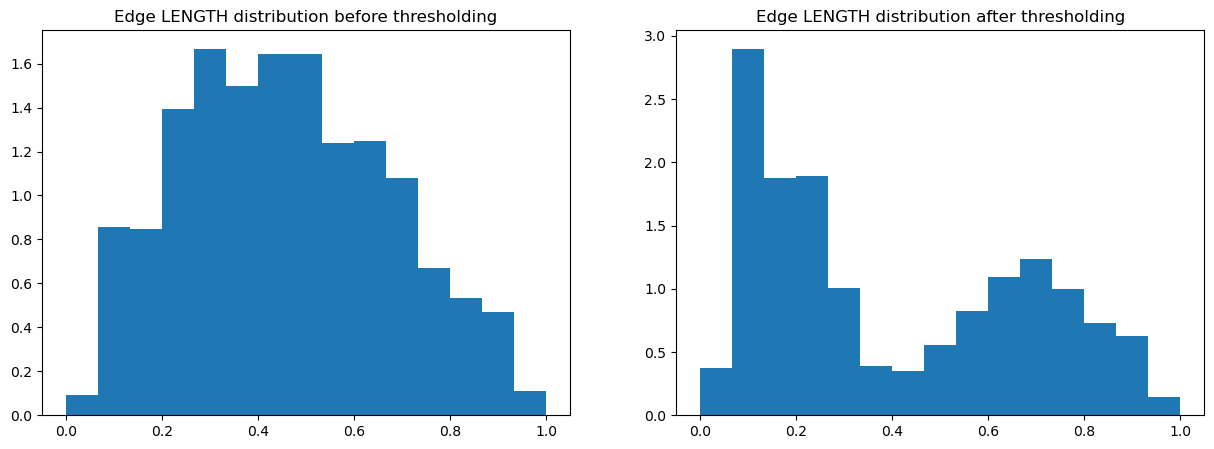

In [74]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(dist_geodesic.flatten(), weights=A.astype(bool).sum(axis=0).flatten(), bins=15,density=True)
axs[0].set_title('Edge LENGTH distribution before thresholding')
axs[1].hist(dist_geodesic.flatten(), weights=A_thresh.astype(bool).sum(axis=0).flatten(), bins=15,density=True)
axs[1].set_title('Edge LENGTH distribution after thresholding')

plt.show()

Text(0.5, 0, 'electrode geodesic distance')

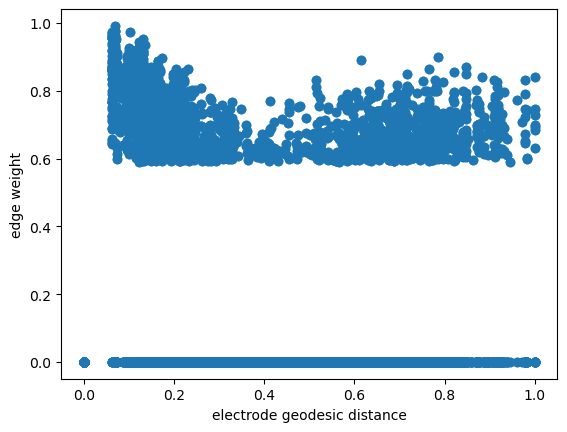

In [57]:
plt.scatter(dist_geodesic.flatten(), A_thresh[0].flatten())
plt.ylabel('edge weight')
plt.xlabel('electrode geodesic distance')

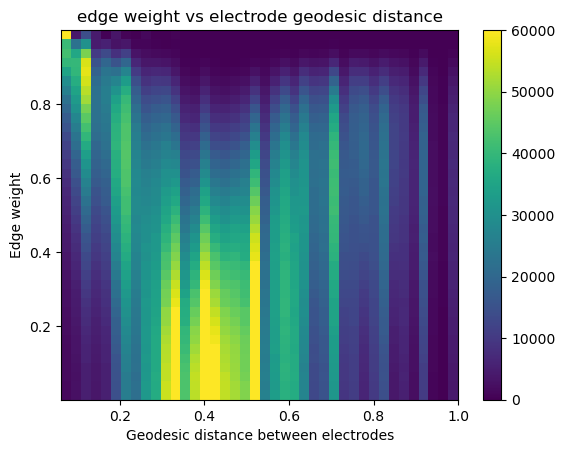

In [23]:
dist_flat = np.broadcast_to(dist_geodesic, A.shape).flatten()
plt.hist2d(dist_flat[dist_flat>0], A.flatten()[A.flatten()>0],bins=40, vmax=60000)
plt.colorbar()
plt.xlabel('Geodesic distance between electrodes')
plt.ylabel('Edge weight')
plt.title('edge weight vs electrode geodesic distance')
plt.show()

## Reordered nodes

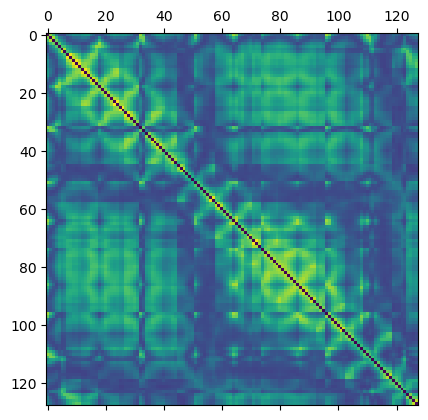

In [28]:
plt.matshow(A.mean(axis=0))

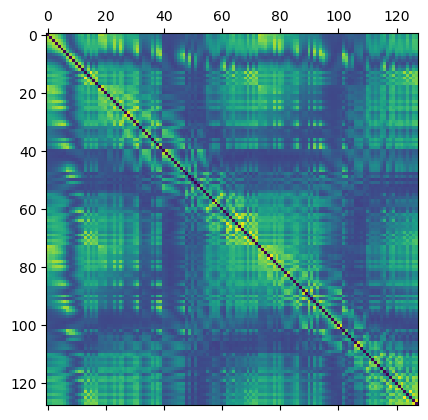

In [27]:
plt.matshow(A.mean(axis=0)[np.ix_(node_order, node_order)])

## Take binary thresholded graph

In [88]:
A_thresh.shape

(2000, 128, 128)

In [89]:
A_bin = A_thresh.copy()
A_bin[A_bin!=0] = 1.
A_bin.shape

(2000, 128, 128)

In [90]:
# count cases of disconnected nodes
disc_graph_counts = 0
disc_nodes_counts = 0
for a in A_bin :
    d = a.sum(axis=0)
    disc_nodes_counts+=np.sum(d==0)
    disc_graph_counts+=np.any(d==0)

In [91]:
disc_graph_counts

1753

In [92]:
disc_nodes_counts

9115

## Create Consensus Graph

In [104]:
def compute_consensus_graph(adjs_bin, density=.2):
    consensus = adjs_bin.sum(axis=0)
    threshold = ut.calculate_threshold(consensus, density)
    consensus[consensus<threshold]=0
    consensus[consensus!=0]=1
    return consensus

In [106]:
Concensus = compute_consensus_graph(A_bin)
Concensus.shape

(128, 128)

## Degree Distribution

In [94]:
D = A_bin.sum(axis=-1)
D.shape

(2000, 128)

In [110]:
D_con = Concensus.sum(axis=-1)
D_con.shape

(128,)

Text(0.5, 1.0, 'Degree Distribution of Consensus Graph')

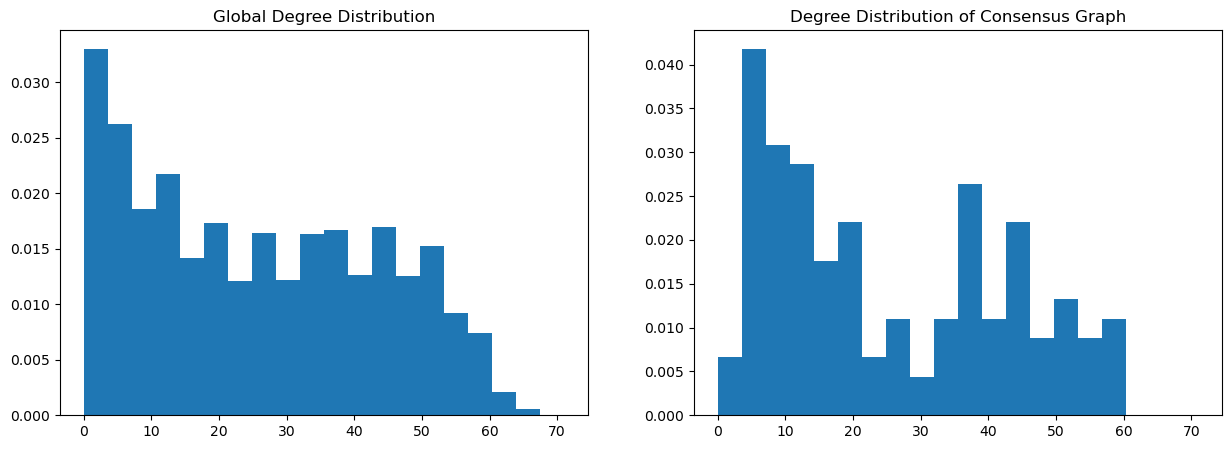

In [120]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
out1 = axs[0].hist(D.flatten(),bins=20,density=True)
axs[0].set_title('Global Degree Distribution')
axs[1].hist(D_con, bins=out1[1],density=True)
axs[1].set_title('Degree Distribution of Consensus Graph')

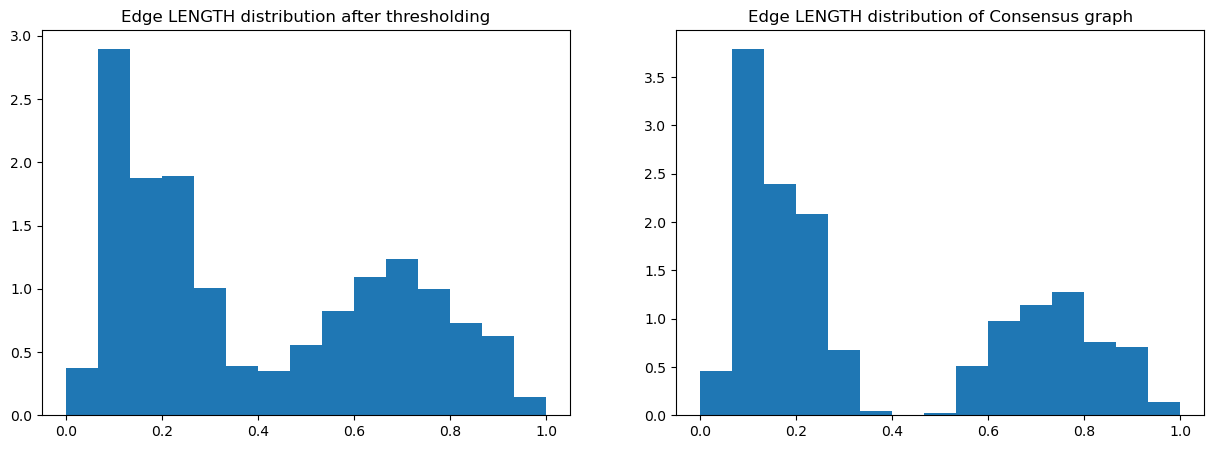

In [108]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(dist_geodesic.flatten(), weights=A_bin.sum(axis=0).flatten(), bins=15,density=True)
axs[0].set_title('Edge LENGTH distribution after thresholding')
axs[1].hist(dist_geodesic.flatten(), weights=Concensus.flatten(), bins=15,density=True)
axs[1].set_title('Edge LENGTH distribution of Consensus graph')

plt.show()

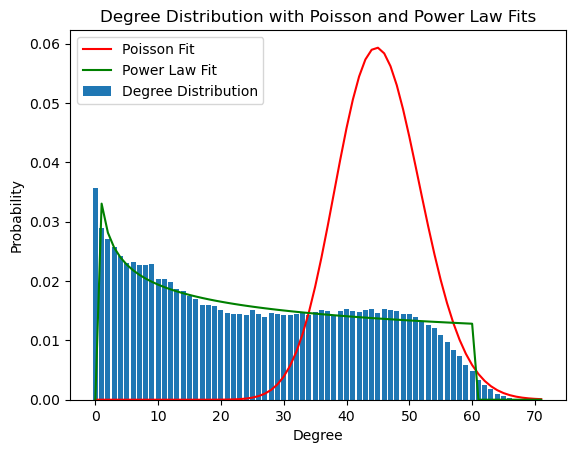

Fitted parameter (lambda): 45.26074887252821
Fitted parameter (alpha): 0.7685246075206983


In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, powerlaw
from scipy.optimize import curve_fit

# Sample degree distribution data
degrees = D.flatten()

# Calculate the degree frequencies
unique_degrees, degree_counts = np.unique(degrees, return_counts=True)

# Normalize the degree distribution
degree_probs = degree_counts / np.sum(degree_counts)

# Define the Poisson distribution function
def poisson_distribution(k, lambd):
    return poisson.pmf(k, lambd)

# Define the power law distribution function
def power_law_distribution(x, alpha, xmin):
    return powerlaw.pdf(x, alpha, scale=xmin)

# Fit the Poisson distribution to the degree distribution
params, _ = curve_fit(poisson_distribution, unique_degrees, degree_probs)

# Fit the power law distribution to the degree distribution
powerlaw_params, _ = curve_fit(power_law_distribution, unique_degrees, degree_probs, bounds=(0, [np.inf, np.max(unique_degrees)]))

# Generate x-values for the fitted Poisson and power law distribution curves
x_values = np.arange(min(unique_degrees), max(unique_degrees) + 1)
#x_values = np.arange(0, max(unique_degrees) + 1)

# Calculate the corresponding y-values using the fitted parameters
poisson_y_values = poisson_distribution(x_values, *params)
powerlaw_y_values = power_law_distribution(x_values, *powerlaw_params)
powerlaw_y_values = powerlaw.pdf(x_values,powerlaw_params[0], scale=60)

# Plot the original degree distribution and the fitted Poisson and power law distributions
plt.bar(unique_degrees, degree_probs, label='Degree Distribution')
plt.plot(x_values, poisson_y_values, 'r-', label='Poisson Fit')
plt.plot(x_values, powerlaw_y_values, 'g-', label='Power Law Fit')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution with Poisson and Power Law Fits')
plt.legend()
plt.show()

# Print the fitted parameter values (lambda and alpha)
print('Fitted parameter (lambda):', params[0])
print('Fitted parameter (alpha):', powerlaw_params[0])


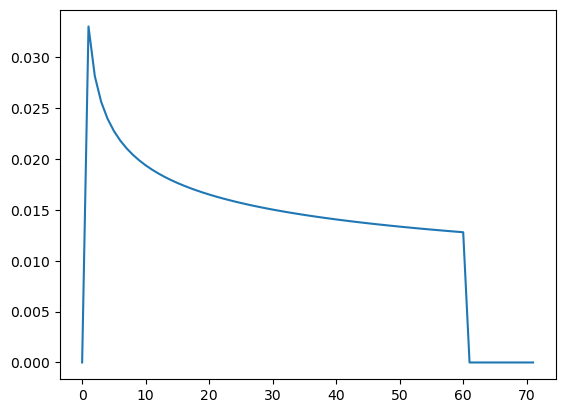

In [144]:
plt.plot(powerlaw_y_values)

In [ ]:
# Erdős-Rényi node degree histogram.
degree_sequence = sorted([d for _, d in er.degree()], reverse=True)  # degree sequence: creating a sorted list
degreeCount = collections.Counter(degree_sequence)
deg, count = zip(*degreeCount.items())

fig, ax = plt.subplots()
ax.bar(deg, count)
ax.set_title("Degree Histogram")
ax.set_ylabel("Count")
ax.set_xlabel("Degree");

In [ ]:
# Poisson distribution.
def poisson(mu, k):
    return np.exp(-mu) * mu**k * (np.math.factorial(k)**-1)

fig, ax = plt.subplots()
ax.bar(deg, count, label='Histogram')

# Poisson distribution
deg_range = np.arange(1,28)
mu = 2*er.size()/N
poiss = N*np.array([poisson(mu, k) for k in deg_range])
ax.plot(deg_range, poiss,'r')

ax.legend()
ax.set_title("Degree Histogram")
ax.set_ylabel("Count")
ax.set_xlabel("Degree");